# Movie Lens Case Study

## Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import chi2 # For Chi-square test - to check independency of categorical variable
from scipy import stats
from statsmodels.formula.api import ols # Importing Ordinary least square
import statsmodels.api as sm
from sklearn.preprocessing import scale # For scaling the data
from sklearn.model_selection import train_test_split # for spliting the data in testing & training dataset
from sklearn.linear_model import LogisticRegression # For logistic model
from sklearn.metrics import accuracy_score # for calculating accuracy
from sklearn.ensemble import RandomForestClassifier as RFC # for Random Forest model
from sklearn.neighbors import KNeighborsClassifier   # For KNN model
import xgboost as xgb # for XGBoost model extreme Gradient model
import warnings
warnings.filterwarnings("default", category=DeprecationWarning) # For removing ignoring warnings

#### Reading the dataset

In [2]:
# considering the sep as the data is seprated by :: in .dat file
movies_df = pd.read_csv(r"G:\Simplilearn\Python\Movielens_case\movies.dat",sep="::",engine='python')
users_df = pd.read_csv(r"G:\Simplilearn\Python\Movielens_case\users.dat",sep="::",engine='python')
ratings_df = pd.read_csv(r"G:\Simplilearn\Python\Movielens_case\ratings.dat",sep="::",engine='python')

# Adding column names
movies_df.columns = ['MovieID','Title','Genres']
users_df.columns = ['UserID','Gender','Age','Occupation','Zip-code']
ratings_df.columns = ['UserID','MovieID','Rating','Timestamp']

In [3]:
# Merging two dataset as both have MovieID as common field and validating via many to many
mer = pd.merge(movies_df,ratings_df,on = ['MovieID'],how='inner',validate='many_to_many')
# Checking for the count for NA values
mer.isnull().sum()

MovieID      0
Title        0
Genres       0
UserID       0
Rating       0
Timestamp    0
dtype: int64

In [4]:
# Merging two dataset as both have UserID as common field and validating via many to many
master_df = pd.merge(mer,users_df,on=['UserID'],how='inner',validate='many_to_many')
# Checking for NA values
master_df.isnull().sum()

MovieID       0
Title         0
Genres        0
UserID        0
Rating        0
Timestamp     0
Gender        0
Age           0
Occupation    0
Zip-code      0
dtype: int64

In [5]:
# Understanding the shape for datasets
print(master_df.shape,mer.shape,movies_df.shape,ratings_df.shape,users_df.shape)

(998080, 10) (998131, 6) (3882, 3) (1000208, 4) (6039, 5)


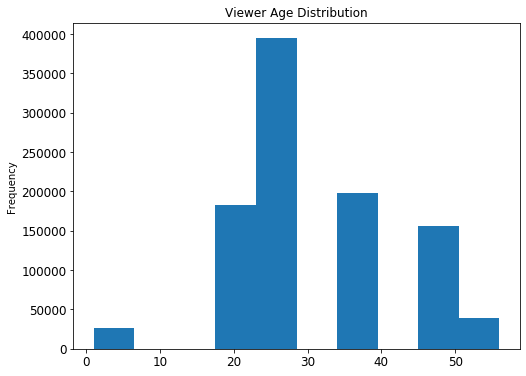

In [6]:
# Histogram for Age distribution
master_df.Age.plot(kind='hist',title = 'Viewer Age Distribution',figsize = (8,6),fontsize= 12)
plt.show()

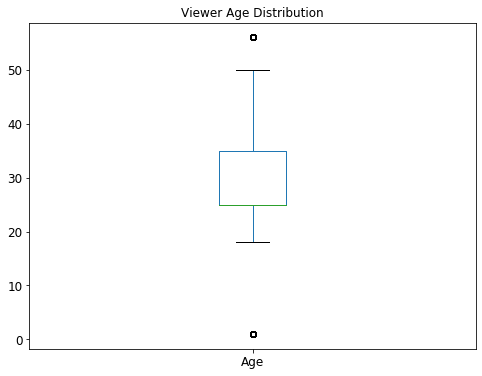

In [7]:
master_df.Age.plot(kind='box',title = 'Viewer Age Distribution',figsize = (8,6),fontsize= 12)

#### Comments:
#### Age of viewers varies from 1 to 55
#### From Boxplot it is clearly visible that IQR is from ~25 - 35

# Understanding ratings data for Toy Story movie

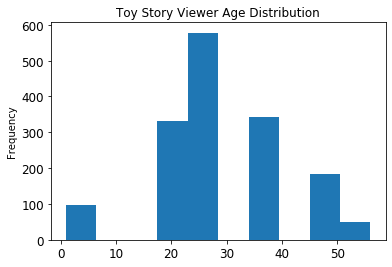

In [81]:
# Getting data for movie Toy Story
rat = master_df[master_df.Title.str.contains('Toy Story')]
rat.Age.plot(kind='hist',title = 'Toy Story Viewer Age Distribution',figsize = (6,4),fontsize= 12)
plt.show()

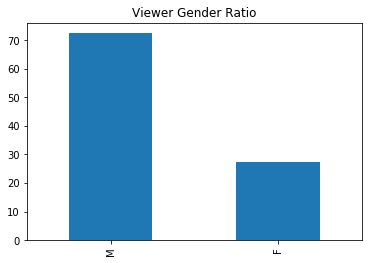

In [80]:
gen = rat.Gender.value_counts(normalize=True)*100
gen.plot(kind='bar',title='Viewer Gender Ratio')
plt.show()
# Graph shows Toy story has 72:28 Male to Female viewers ratio

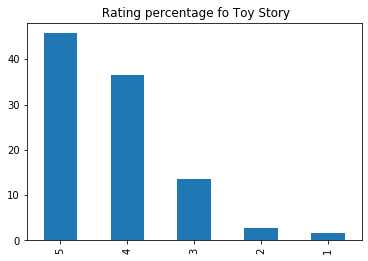

In [78]:
R = rat.Rating.value_counts(normalize =True)*100
R.plot(kind='Bar',title=' Rating percentage fo Toy Story')
plt.show()
# This Graphs shows % distribution of ratings

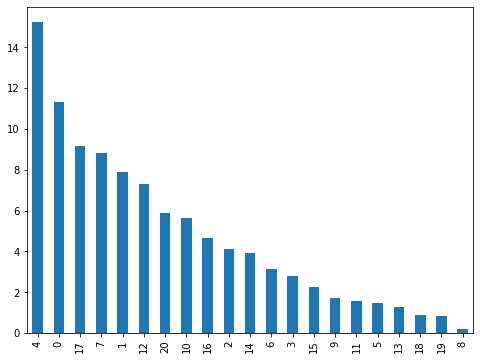

In [85]:
occ = rat.Occupation.value_counts(normalize=True)*100
occ.plot(kind='bar',figsize=(8,6))
plt.show()
# This shows % distribution of viewers occupation

In [111]:
#Top 25 movies by viewership rating
df = master_df.groupby('Title').Rating.mean()
df.sort_values(ascending= False).head(25)


Title
Song of Freedom (1936)                                                 5.000000
Ulysses (Ulisse) (1954)                                                5.000000
Schlafes Bruder (Brother of Sleep) (1995)                              5.000000
Follow the Bitch (1998)                                                5.000000
Bittersweet Motel (2000)                                               5.000000
Lured (1947)                                                           5.000000
Baby, The (1973)                                                       5.000000
Smashing Time (1967)                                                   5.000000
Gate of Heavenly Peace, The (1995)                                     5.000000
One Little Indian (1973)                                               5.000000
I Am Cuba (Soy Cuba/Ya Kuba) (1964)                                    4.800000
Lamerica (1994)                                                        4.750000
Apple, The (Sib) (1998)           

In [112]:
# Find the ratings for all the movies reviewed by for a particular user of user id = 2696
master_df[master_df.UserID == 2696][['MovieID','Title','Genres','Rating']]

,MovieID,Title,Genres,Rating
988372,350,"Client, The (1994)",Drama|Mystery|Thriller,3
988373,800,Lone Star (1996),Drama|Mystery,5
988374,1092,Basic Instinct (1992),Mystery|Thriller,4
988375,1097,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi,3
988376,1258,"Shining, The (1980)",Horror,4
988377,1270,Back to the Future (1985),Comedy|Sci-Fi,2
988378,1589,Cop Land (1997),Crime|Drama|Mystery,3
988379,1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,4
988380,1625,"Game, The (1997)",Mystery|Thriller,4
988381,1644,I Know What You Did Last Summer (1997),Horror|Mystery|Thriller,2


# Feature Engineering :

In [125]:
master_df.head(1)

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
0,2,Jumanji (1995),Adventure|Children's|Fantasy,10,5,979168267,F,35,1,95370


In [8]:
master_df.Genres = master_df.Genres.str.split(pat='|')

In [9]:
# Taking only a small chunks as whole dataset is taking too much time
chunks_df = master_df[:80000]
print(chunks_df.shape,master_df.shape)

(80000, 10) (998080, 10)


In [10]:
# Storing all Genres at one place
y = []
for n in range(len(chunks_df.Genres)):
    y = y + chunks_df.iloc[n].Genres

In [11]:
# Getting only the unique Genres and converting to series
unique_genres = set(y)
unique_genres = list(unique_genres)
unique_genres = pd.Series(unique_genres)
unique_genres

0          Comedy
1        Thriller
2         Fantasy
3          Action
4           Crime
5         Mystery
6           Drama
7          Horror
8       Adventure
9         Musical
10         Sci-Fi
11        Western
12      Film-Noir
13        Romance
14      Animation
15     Children's
16            War
17    Documentary
dtype: object

In [12]:
coded = pd.DataFrame()

for row in chunks_df.Genres:
    x = unique_genres.isin(row)
    coded = coded.append(x,ignore_index = True)
    


In [13]:
coded.columns = unique_genres
coded.head(2)

,Comedy,Thriller,Fantasy,Action,Crime,Mystery,Drama,Horror,Adventure,Musical,Sci-Fi,Western,Film-Noir,Romance,Animation,Children's,War,Documentary
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [14]:
final_df = pd.concat([chunks_df,coded],axis = 1)
final_df.head(2)

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,...,Adventure,Musical,Sci-Fi,Western,Film-Noir,Romance,Animation,Children's,War,Documentary
0,2,Jumanji (1995),"[Adventure, Children's, Fantasy]",10,5,979168267,F,35,1,95370,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,7,Sabrina (1995),"[Comedy, Romance]",10,4,978227763,F,35,1,95370,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [15]:
print(chunks_df.shape,coded.shape,final_df.shape)

(80000, 10) (80000, 18) (80000, 28)


In [16]:
# Remove not useful features as they won't be helping the model
final_df = final_df.drop(columns=['MovieID','Title','Genres','UserID','Zip-code'])
final_df.head()

,Rating,Timestamp,Gender,Age,Occupation,Comedy,Thriller,Fantasy,Action,Crime,...,Adventure,Musical,Sci-Fi,Western,Film-Noir,Romance,Animation,Children's,War,Documentary
0,5,979168267,F,35,1,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,4,978227763,F,35,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3,978230586,F,35,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,979168160,F,35,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,978230090,F,35,1,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


# Feature Selection:

In [17]:
final_df.Gender = pd.Categorical(final_df.Gender)
final_df.Occupation = pd.Categorical(final_df.Occupation)

### Since it is a classification problem we will use Chi-square test for categorical values
## Ho  : There is no relationship between Gender & Ratings
## Ha  : There is relationship between Gender & Ratings

In [139]:
contengency_tab = pd.crosstab(final_df.Gender,final_df.Rating)
chi_square , p_value, degrees_of_freedom, expected_frequencies = stats.chi2_contingency(contengency_tab)

alpha = 0.05
print(contengency_tab)

print('Significance level: ',alpha)
print('Degree of Freedom: ',degrees_of_freedom)
print('p-value:',p_value)
print('chi_square:',chi_square)
print('Expected frequency: ',expected_frequencies)

if p_value <= alpha:
    print("Rejecting H0 - There is relationship between two Gender & Ratings")
else:
    print("Fail to reject H0 - There is no relationship between Gender & Ratings")




Rating     1     2      3      4      5
Gender                                 
F       1054  1782   4539   5523   3291
M       4919  8568  18027  21042  11255
Significance level:  0.05
Degree of Freedom:  4
p-value: 2.9072108464920323e-29
chi_square: 139.9400624799809
Expected frequency:  [[ 1208.7112125  2094.451875   4566.512175   5375.7598125  2943.564925 ]
 [ 4764.2887875  8255.548125  17999.487825  21189.2401875 11602.435075 ]]
Rejecting H0 - There is relationship between two Gender & Ratings


### Testing for Occupation feature
## Ho : There is no relationship between Occupation & Ratings
## Ha : There is  relationship between Occupation & Ratings

In [140]:
contengency_tab1 = pd.crosstab(final_df.Rating,final_df.Occupation)
chi_square , p_value, degrees_of_freedom, expected_frequencies = stats.chi2_contingency(contengency_tab1)

alpha = 0.05
print(contengency_tab1)

print('Significance level: ',alpha)
print('Degree of Freedom: ',degrees_of_freedom)
print('p-value:',p_value)
print('chi_square:',chi_square)

if p_value <= alpha:
    print("Rejecting H0 - There is relationship between two Occupation & Ratings")
else:
    print("Fail to reject H0 - There is no relationship between Occupation & Ratings")

Occupation    0     1     2     3     4    5     6     7    8    9     10  \
Rating                                                                      
1           1342   240   170   292  1096   27   163   678   34   31   200   
2           1932   561   437   579  1556   71   261  1042  100   71   398   
3           3981  1628  1019  1568  3081  128   536  1905  317  333   826   
4           4567  2203  1217  2064  3650  205  1023  1761  305  450  1087   
5           2365  1163   589  1315  2100  164   738   812  210  302   609   

Occupation   11    12   14   15   16    17  18   19    20  
Rating                                                     
1            65   214   63    3  166   440  69  232   448  
2           140   482  212   13  482   972  30  352   659  
3           412  1058  490   65  996  2131  24  654  1414  
4           841  1378  403  138  953  2305  57  416  1542  
5           372   846  205  119  300  1421  33  200   683  
Significance level:  0.05
Degree of Free

## For continous Variable we will use anova(OLS) to check for dependency

### Ho : There is no significant difference in Rating across age
### Ho : There is significant difference in Rating across age

In [141]:
model = ols('Rating ~ Age',final_df).fit()
result = sm.stats.anova_lm(model)

alpha = 0.01
print(result)
print("p-value:",model.f_pvalue)
print("Alpha Value:",alpha)

if model.f_pvalue <= alpha:
    print("Rejecting H0 "" There is significant difference in Rating across age")
else:
    print("Fail to reject H0 : There is no significant difference in Rating across age")

               df         sum_sq    mean_sq          F        PR(>F)
Age           1.0      83.535317  83.535317  63.647086  1.507836e-15
Residual  79998.0  104995.510671   1.312477        NaN           NaN
p-value: 1.5078359278993743e-15
Alpha Value: 0.01
Rejecting H0  There is significant difference in Rating across age


## For View Timestamp:

### Ho : There is no significant difference in Rating with view timestamp
### Ha : There is significant difference in Rating with view timestamp

In [142]:
model1 = ols('Rating ~ Timestamp',final_df).fit()
result1 = sm.stats.anova_lm(model1)

alpha = 0.05
print(result1)
print("p-value:",model1.f_pvalue)
print("Alpha Value:",alpha)

if model1.f_pvalue <= alpha:
    print("Rejecting H0 "" There is significant difference in Rating with view timestamp ")
else:
    print("Fail to reject H0 : There is no significant difference in Rating with view timestamp")

                df         sum_sq   mean_sq         F    PR(>F)
Timestamp      1.0       6.049114  6.049114  4.605532  0.031872
Residual   79998.0  105072.996873  1.313445       NaN       NaN
p-value: 0.031871963388354886
Alpha Value: 0.05
Rejecting H0  There is significant difference in Rating with view timestamp 


In [143]:
# Here p-value is 0.03 which means there is only 3% chances that there will be no significant difference in Rating with timestamp

## Predictive Modelling

In [18]:
final_df.Gender = final_df.Gender.replace({'F':0,'M':1}) # Encoding to numeric that will be used for models
response = final_df[['Rating']]
feature = final_df[final_df.columns[1:]]
feature = scale(feature)
x_train, x_test , y_train, y_test = train_test_split(feature,response,test_size = 0.4,shuffle=True,random_state = 43)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [19]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(48000, 22) (32000, 22) (48000, 1) (32000, 1)


In [20]:
final_df['Rating'].value_counts(normalize = True)
# majority class baseline = 0.33

4    0.332062
3    0.282075
5    0.181825
2    0.129375
1    0.074663
Name: Rating, dtype: float64

## Logistic Regression for multiclass classification

In [21]:
LoReg = LogisticRegression()
LoReg.fit(x_train,y_train)
y_pred  = LoReg.predict(x_train)
print('Result of Logistic Regression model:')
print('Train accuracy score : ',accuracy_score(y_train,y_pred))
print('Test accuracy score : ',accuracy_score(y_test,LoReg.predict(x_test)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Result of Logistic Regression model:
Train accuracy score :  0.3345416666666667
Test accuracy score :  0.3373125


In [29]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=0.95)
pca_model.fit(x_train)
x_train_transform = pca_model.transform(x_train)
x_test_transform = pca_model.transform(x_test)
print(x_train_transform.shape,x_test_transform.shape)
LoReg = LogisticRegression(penalty='l1')
LoReg.fit(x_train_transform,y_train)
y_pred = LoReg.predict(x_test_transform)
print(accuracy_score(y_pred,y_test))
LoReg

(48000, 20) (32000, 20)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.3349375


### Logistic Regression model no better as its accuarcy is same as baseline i.e. 0.33

In [149]:
rfc_s = RFC()

rfc_s.fit(x_train,y_train)
print('Train accuarcy score: ', accuracy_score(y_train,rfc_s.predict(x_train)))
print('Test accuarcy score: ', accuracy_score(y_test,rfc_s.predict(x_test)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Train accuarcy score:  0.9178541666666666
Test accuarcy score:  0.35534375


### Random Forest model performs very good in training set but not in test dataset

In [150]:
knn = KNeighborsClassifier()
knn.fit(x_train,y_train)

print('Train accuarcy score : ', accuracy_score(y_train,knn.predict(x_train)))
print('Test accuarcy score : ', accuracy_score(y_test,knn.predict(x_test)))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


Train accuarcy score :  0.5496666666666666
Test accuarcy score :  0.34628125


### K-Neighbours model is better than Random Forest but not upto the mark

In [26]:
xg_train = xgb.DMatrix(x_train_transform, label = y_train)
xg_test = xgb.DMatrix(x_test_transform, label = y_test)

# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
param['silent'] = 1 # cleans up the output
param['num_class'] = 6 # number of classes in target label
watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 200
bst = xgb.train(param, xg_train, num_round, watchlist)


[0]	train-merror:0.632604	test-merror:0.653219
[1]	train-merror:0.622563	test-merror:0.652656
[2]	train-merror:0.617625	test-merror:0.650406
[3]	train-merror:0.612042	test-merror:0.6495
[4]	train-merror:0.608583	test-merror:0.649688
[5]	train-merror:0.602292	test-merror:0.649312
[6]	train-merror:0.599083	test-merror:0.647375
[7]	train-merror:0.593437	test-merror:0.64575
[8]	train-merror:0.592521	test-merror:0.646531
[9]	train-merror:0.589708	test-merror:0.645375
[10]	train-merror:0.587	test-merror:0.644281
[11]	train-merror:0.584708	test-merror:0.643281
[12]	train-merror:0.583417	test-merror:0.644125
[13]	train-merror:0.580458	test-merror:0.644094
[14]	train-merror:0.579042	test-merror:0.64375
[15]	train-merror:0.577604	test-merror:0.643125
[16]	train-merror:0.57525	test-merror:0.642719
[17]	train-merror:0.573812	test-merror:0.642906
[18]	train-merror:0.571437	test-merror:0.642875
[19]	train-merror:0.570333	test-merror:0.643
[20]	train-merror:0.567771	test-merror:0.642625
[21]	train-me

In [27]:
print('Train accuracy score:',accuracy_score(y_train,bst.predict(xg_train)))
print('Test accuracy score:',accuracy_score(y_test,bst.predict(xg_test)))

Train accuracy score: 0.62
Test accuracy score: 0.37278125


### when num_rounds = 100 , Training accuracy score was 0.53 but test score remain same to 0.42
### XGBoost Models is better among others used but needs to fine tuned

# Thank You !!